# Проблема 1

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, chi2
import yfinance as yf

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import VECM

# set pd/np parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(legacy='1.21')
np.set_printoptions(suppress=True)

# set plt/sns parameters
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("whitegrid")

In [71]:
# красивые функции с семинара:

def adf_test(timeseries, **kwargs):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, **kwargs)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries, **kwargs):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, **kwargs)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def coint_test(series1, series2, **kwargs):
    print("Results of Cointegration Test (Engle-Granger):")
    coint_result = sm.tsa.stattools.coint(series1, series2, **kwargs)
    
    test_statistic, p_value, critical_values = coint_result

    coint_output = pd.Series(
        [test_statistic, p_value],
        index=["Test Statistic", "p-value"]
    )
    
    critical_levels = ["10%", "5%", "1%"]
    for i, level in enumerate(critical_levels):
        coint_output[f"Critical Value ({level})"] = critical_values[i]
    
    print(coint_output)

def plot_acf_pacf(series):
    fig, axs = plt.subplots(2,1)
    plot_acf(series, ax=axs[0])
    plot_pacf(series, ax=axs[1])
    plt.tight_layout()
    plt.show()

### (1) Show the plots of the logs for average RUB/USD exchange rate and Brent oil price variables

In [212]:
data = pd.read_csv('rurusdbrent.txt', sep='\t')
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1)) # к каждому месяцу устанавливаем 1 число
data.set_index('date', inplace=True)
data

,year,month,rubusdavg,rubusdmin,rubusdmax,workdays,wtiprice,brentprice
date,,,,,,,,
2000-01-01,2000,1,27.884,27.203,28.862,21,27.260,25.510
2000-02-01,2000,2,28.738,28.068,29.317,21,29.370,27.780
2000-03-01,2000,3,29.304,29.058,29.612,23,29.840,27.490
2000-04-01,2000,4,29.851,29.214,31.105,18,25.720,22.760
2000-05-01,2000,5,31.101,28.251,31.841,22,28.790,27.740
...,...,...,...,...,...,...,...,...
2017-06-01,2017,6,57.983,56.577,59.793,22,45.180,46.370
2017-07-01,2017,7,59.744,58.940,60.789,21,46.630,48.480
2017-08-01,2017,8,59.539,58.414,60.703,23,48.040,51.700


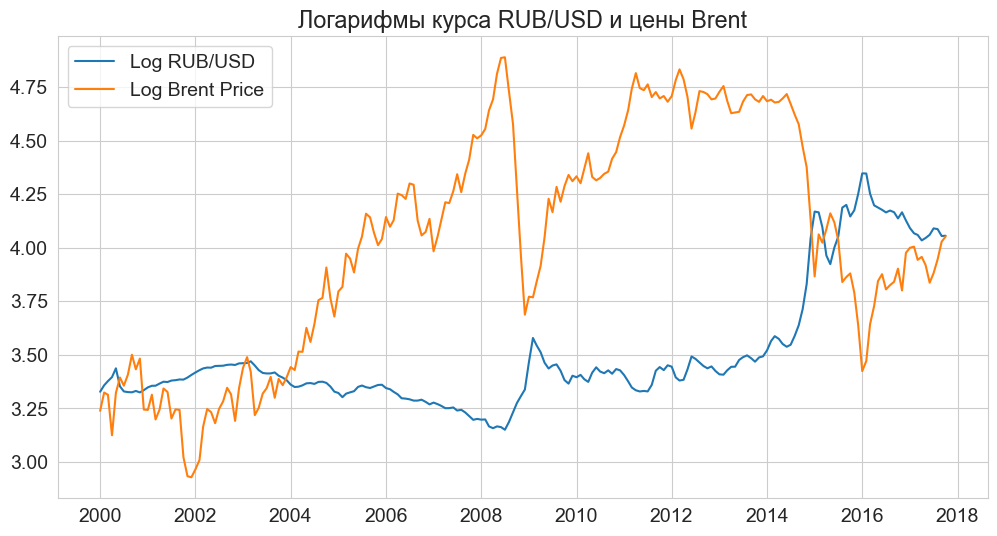

In [214]:
data['log_rubusd'] = np.log(data['rubusdavg'])
data['log_brent'] = np.log(data['brentprice'])
plt.figure(figsize=(12, 6))
plt.plot(data['log_rubusd'], label='Log RUB/USD')
plt.plot(data['log_brent'], label='Log Brent Price')
plt.legend()
plt.title('Логарифмы курса RUB/USD и цены Brent')
plt.show()

Ряды нестационарные. Видно, что мат. ожидания не константы

### (2) Construct logarithmic returns for the average exchange rate and Brent oil price. Plot them

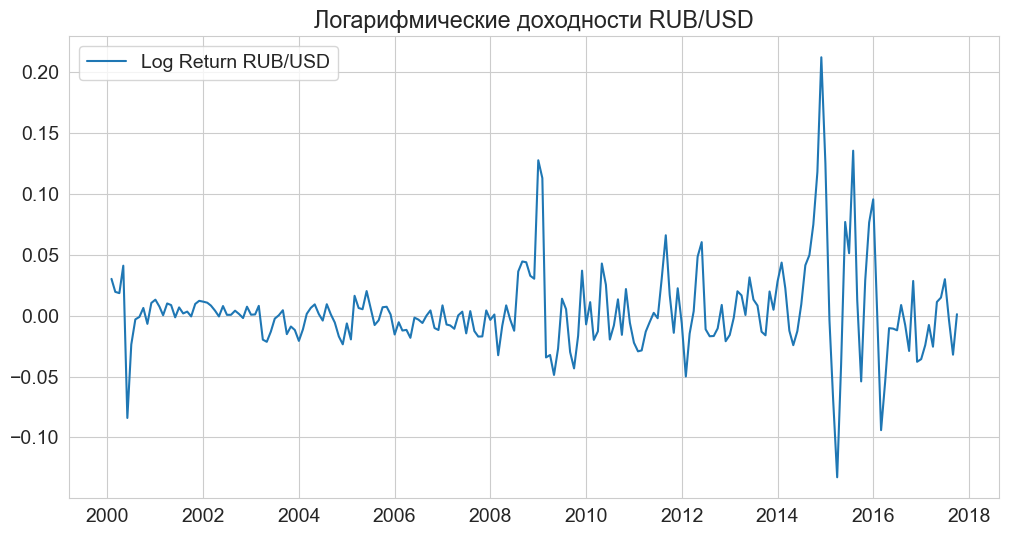

In [216]:
data['log_rubusd_ret'] = data['log_rubusd'].diff()
data['log_brent_ret'] = data['log_brent'].diff()

data.dropna(inplace=True)  # удаляем пропущенные значения после разности

plt.figure(figsize=(12, 6))
plt.plot(data['log_rubusd_ret'], label='Log Return RUB/USD')
plt.legend()
plt.title('Логарифмические доходности RUB/USD')
plt.show()

Уже более стационарный ряд, колеблется вокруг некоторого среднего, близкого к нулю. 

При этом видны периоды низкой и высокой волатильности (кризис 2008 года, кризис 2014 года; после 2013 года волатильность увеличилась с введением плавающего курса)

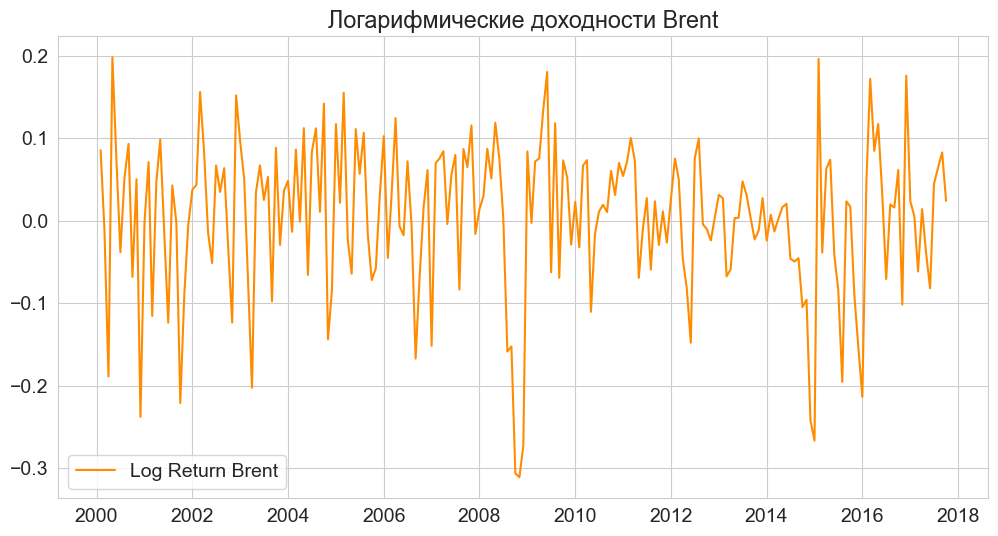

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(data['log_brent_ret'], label='Log Return Brent', color = 'darkorange')
plt.legend()
plt.title('Логарифмические доходности Brent')
plt.show()

Уже более стационарный ряд, мат. ожидание больше похоже на константу

### (3) Аugmented Dickey–Fuller procedure

#### Спецификация augmented, без отдельного выделения тренда

In [220]:
# autolag='BIC'  автоматически оптимизирует количество лагов по критерию BIC (он же критерий Шварца)
# можно не перебирать модели

print ('Спецификация augmented, без отдельного выделения тренда', end='\n\n')
adf_test(data['log_rubusd_ret'], autolag='BIC') 
print ()
adf_test(data['log_brent_ret'], autolag='BIC')

Спецификация augmented, без отдельного выделения тренда

Results of Dickey-Fuller Test:
Test Statistic                 -9.656
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used   211.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -11.730
p-value                         0.000
#Lags Used                      0.000
Number of Observations Used   212.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64


Нулевая гипотеза теста Дики-Фуллера - ряд нестационарный. 
p-value обоих рядов < 5%, значит, нулевая гипотеза отвергается, ряды не нестационарные (стационарные), единичных корней нет

#### Спецификация с time trend

In [222]:
print ('Спецификация с time trend', end='\n\n')
adf_test(data['log_rubusd_ret'], autolag='BIC', regression='ct')
print ()
adf_test(data['log_brent_ret'], autolag='BIC', regression='ct')

Спецификация с time trend

Results of Dickey-Fuller Test:
Test Statistic                 -9.723
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used   211.000
Critical Value (1%)            -4.002
Critical Value (5%)            -3.432
Critical Value (10%)           -3.139
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -11.735
p-value                         0.000
#Lags Used                      0.000
Number of Observations Used   212.000
Critical Value (1%)            -4.002
Critical Value (5%)            -3.431
Critical Value (10%)           -3.139
dtype: float64


Такая отдельная спецификация с трендом нужна, чтобы отличать нестационарные ряды от тренд-стационарных. Допустим, если бы тест Дики-Фулера с константой (дефолтная опция) показал, что ряд нестационарный, а спецификация с трендом показала бы, что ряд стационарный, мы бы знали, что ряд тренд-стационарный.

В случае с рядами доходностей RUB/USD и Brent результаты тестов с разными спецификациями совпадают, ряды являются стационарными

### (4) Use the KPSS test

In [224]:
kpss_test(data['log_rubusd_ret'], regression='c', nlags='auto') # тест просто с константой
print ()
kpss_test(data['log_brent_ret'], regression='c', nlags='auto')

Results of KPSS Test:
Test Statistic          0.170
p-value                 0.100
Lags Used               2.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64

Results of KPSS Test:
Test Statistic          0.134
p-value                 0.100
Lags Used               4.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64


/var/folders/6p/8d5pp0rd4_sbkn9mzjsq45rr0000gn/T/ipykernel_17328/3489382996.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = sm.tsa.stattools.kpss(timeseries, **kwargs)
/var/folders/6p/8d5pp0rd4_sbkn9mzjsq45rr0000gn/T/ipykernel_17328/3489382996.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = sm.tsa.stattools.kpss(timeseries, **kwargs)


Нулевая гипотеза теста KPSS: ряд стационарный. p-value обоих рядов > 0,05, поэтому на 5% уровне значимости нулевая гипотеза не отвергается, ряд стационарный. Результаты тестов ADF и KPSS совпадают. 

Но если бы уровень значимости был бы более 10%, то результаты тестов уже бы расходились. 

# Проблема 2

### (2) logs for the average RUB/USD exchange rate lrubusd and for the Brent oil price series lbrent. Plot them together.

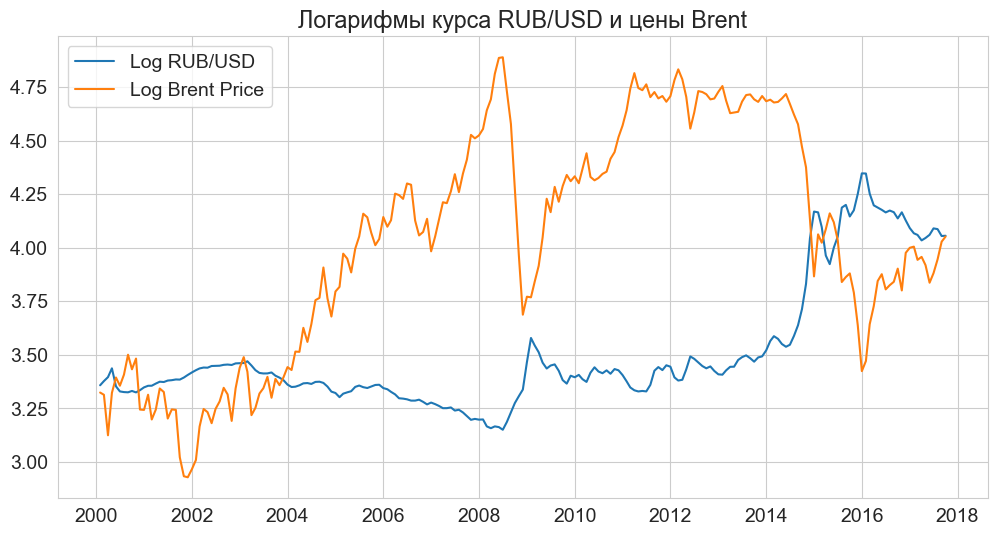

In [226]:
plt.figure(figsize=(12, 6))
plt.plot(data['log_rubusd'], label='Log RUB/USD')
plt.plot(data['log_brent'], label='Log Brent Price')
plt.legend()
plt.title('Логарифмы курса RUB/USD и цены Brent')
plt.show()

Do you see some common patterns in both series? Есть какие-то протинаправленные тренды с 2004 года (тренды с отрицательной корреляцией). Имеется экономическое обоснование: цены на нефть растут -> приток валютной выручки в страну -> рубль дорожает -> курс RUB/USD падает. И наоборот.

### (3) What is a spurious regression?

Spurious regression (ложная регрессия) -  ситуация, когда мы строим регрессию y на x, при этом y и х имеют внутри себя тренды (детерминистические или же стохастические). Тренды могут совпадать, регрессия с большой вероятностью покажет, что коэффициенты значимые

### (4) Simple regression of lrubusd on lbrent

In [228]:
y = data['log_rubusd']
X = sm.add_constant(data['log_brent'])
model = sm.OLS(y, X).fit(cov_type = 'HC0') # использую робастные ошибки
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_rubusd   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     7.630
Date:                Fri, 14 Feb 2025   Prob (F-statistic):            0.00625
Time:                        22:02:29   Log-Likelihood:                -38.171
No. Observations:                 213   AIC:                             80.34
Df Residuals:                     211   BIC:                             87.07
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7894      0.111     34.018      0.0

Ошибки робастные. Коэффициент при log_brent значимый на 5% уровне значимости. R^2 небольшой

Без робастных ошибок коэффициент при log_brent незначимый на 5% уровне значимости.

### (5) lrubusd and lbrent are cointegrated? Use the standard Dickey–Fuller test and the ADF test with two lags

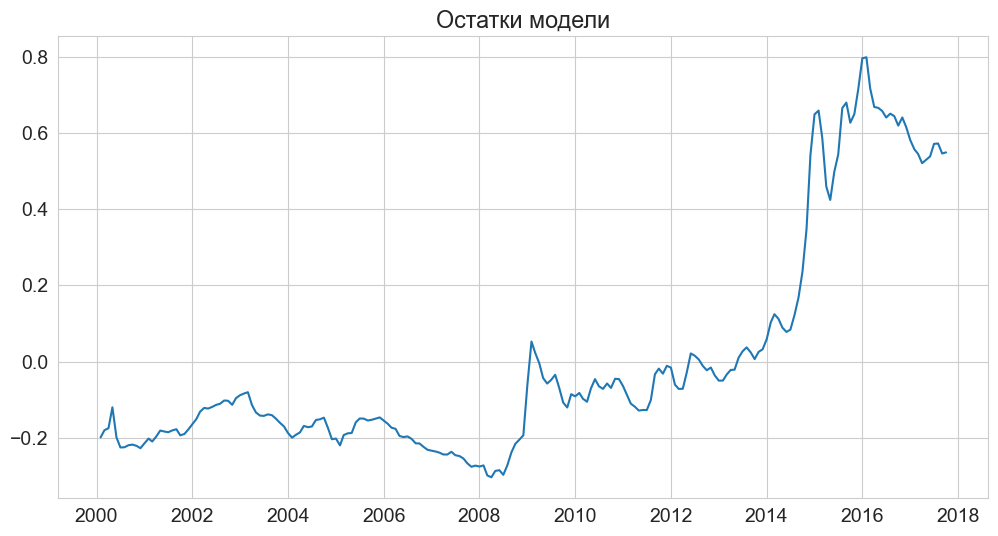

In [230]:
residuals = model.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Остатки модели')
plt.show()

In [169]:
# стандартный Дики-Фуллер - один лаг, с константой
print ('Тест для 1 лага')
adf_test(residuals, maxlag=1)
print ()

# Дики-Фуллер с оптимальным по BIC количеством лагов
print ('Дики-Фуллер с оптимальным по BIC количеством лагов')
adf_test(residuals, autolag='BIC')
print ()

# Дики-Фуллер augmented с 2 лагами
print ('Дики-Фуллер augmented с 2 лагами')
adf_test(residuals, maxlag=2)

Тест для 1 лага
Results of Dickey-Fuller Test:
Test Statistic                 -0.778
p-value                         0.825
#Lags Used                      1.000
Number of Observations Used   209.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64

Дики-Фуллер с оптимальным по BIC количеством лагов
Results of Dickey-Fuller Test:
Test Statistic                 -0.300
p-value                         0.926
#Lags Used                      2.000
Number of Observations Used   208.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.876
Critical Value (10%)           -2.574
dtype: float64

Дики-Фуллер augmented с 2 лагами
Results of Dickey-Fuller Test:
Test Statistic                 -0.300
p-value                         0.926
#Lags Used                      2.000
Number of Observations Used   208.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.876
Critical Value 

Во всех тестах p-value > 0,05, значит, нельзя отвергнуть нулевую гипотезу о нестационарности (видно и по графику).

По идее, для проверки остатков должны использоваться другие критические значения, но у нас нулевая гипотеза не была отвергнута даже без этого, то есть и с нестандартными критическими значениями она не была бы отвергнута. 

Остатки нестационарные, значит, ряды не могут называться коинтегрированными

### (6) Add a linear time trend to the regression from part (4) and now test for cointegration

In [232]:
X_trend = sm.add_constant(pd.concat([data['log_brent'], pd.Series(np.arange(len(data)), index=data.index, name='trend')], axis=1))
model_trend = sm.OLS(y, X_trend).fit(cov_type = 'HC0')
print(model_trend.summary())

                            OLS Regression Results                            
Dep. Variable:             log_rubusd   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     1294.
Date:                Fri, 14 Feb 2025   Prob (F-statistic):          7.99e-119
Time:                        22:02:41   Log-Likelihood:                 253.70
No. Observations:                 213   AIC:                            -501.4
Df Residuals:                     210   BIC:                            -491.3
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8084      0.042    113.450      0.0

Коэффициент при log_brent значимый. R^2, R^2 adj., AIC, BIC более оптимальные

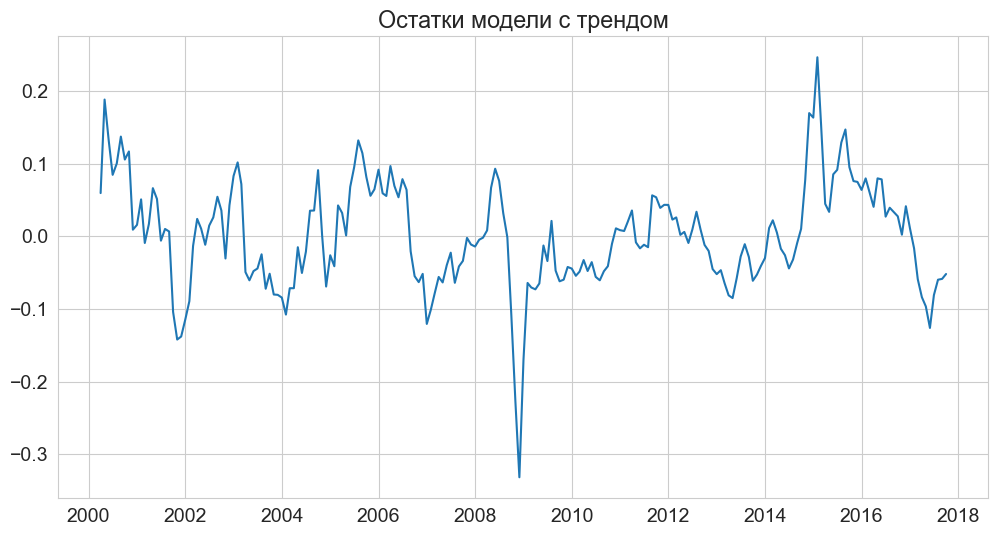

In [191]:
residuals_trend = model_trend.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals_trend)
plt.title('Остатки модели с трендом')
plt.show()

In [246]:
# стандартный Дики-Фуллер - один лаг, с константой
print ('Тест для 1 лага')
adf_test(residuals_trend, maxlag=1)
print ()

# Дики-Фуллер с оптимальным по BIC количеством лагов
print ('Дики-Фуллер с оптимальным по BIC количеством лагов')
adf_test(residuals_trend, autolag='BIC')
print ()

# Дики-Фуллер augmented с 2 лагами
print ('Дики-Фуллер augmented с 2 лагами')
adf_test(residuals_trend, autolag = None, maxlag=2)

Тест для 1 лага
Results of Dickey-Fuller Test:
Test Statistic                 -5.315
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used   209.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64

Дики-Фуллер с оптимальным по BIC количеством лагов
Results of Dickey-Fuller Test:
Test Statistic                 -5.315
p-value                         0.000
#Lags Used                      1.000
Number of Observations Used   209.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64

Дики-Фуллер augmented с 2 лагами
Results of Dickey-Fuller Test:
Test Statistic                 -4.607
p-value                         0.000
#Lags Used                      2.000
Number of Observations Used   208.000
Critical Value (1%)            -3.462
Critical Value (5%)            -2.876
Critical Value 

p-value < 0,05, нулевая гипотеза о нестационарности отвергается, ряд остатков модели стационарный

### (7) Does it appear that RUB/USD exchange rate and oil prices have a long-run equilibrium relationship?

1) Ряды RUB/USD и  Brent являются нестационарными (есть единичный корень). В идеале надо было бы проверить, что дельты этих рядов уже стационарные, то есть ряды интегрированные 1 порядка.
2) Остатки регрессии RUB/USD на Brent нестационарны без тренда, то есть в этом случае не можем говорить о коинтеграции и долгосрочной связи. При этом остатки становятся стационарными при включении линейного тренда, то есть, если сделать поправку на некоторый тренд, существует долгосрочное равновесие. Такая поправка на тренд может, наверное, противоречить стандартному пониманию коинтеграции; коэффициент при переменной тренд статистически значим

# Проблема 3

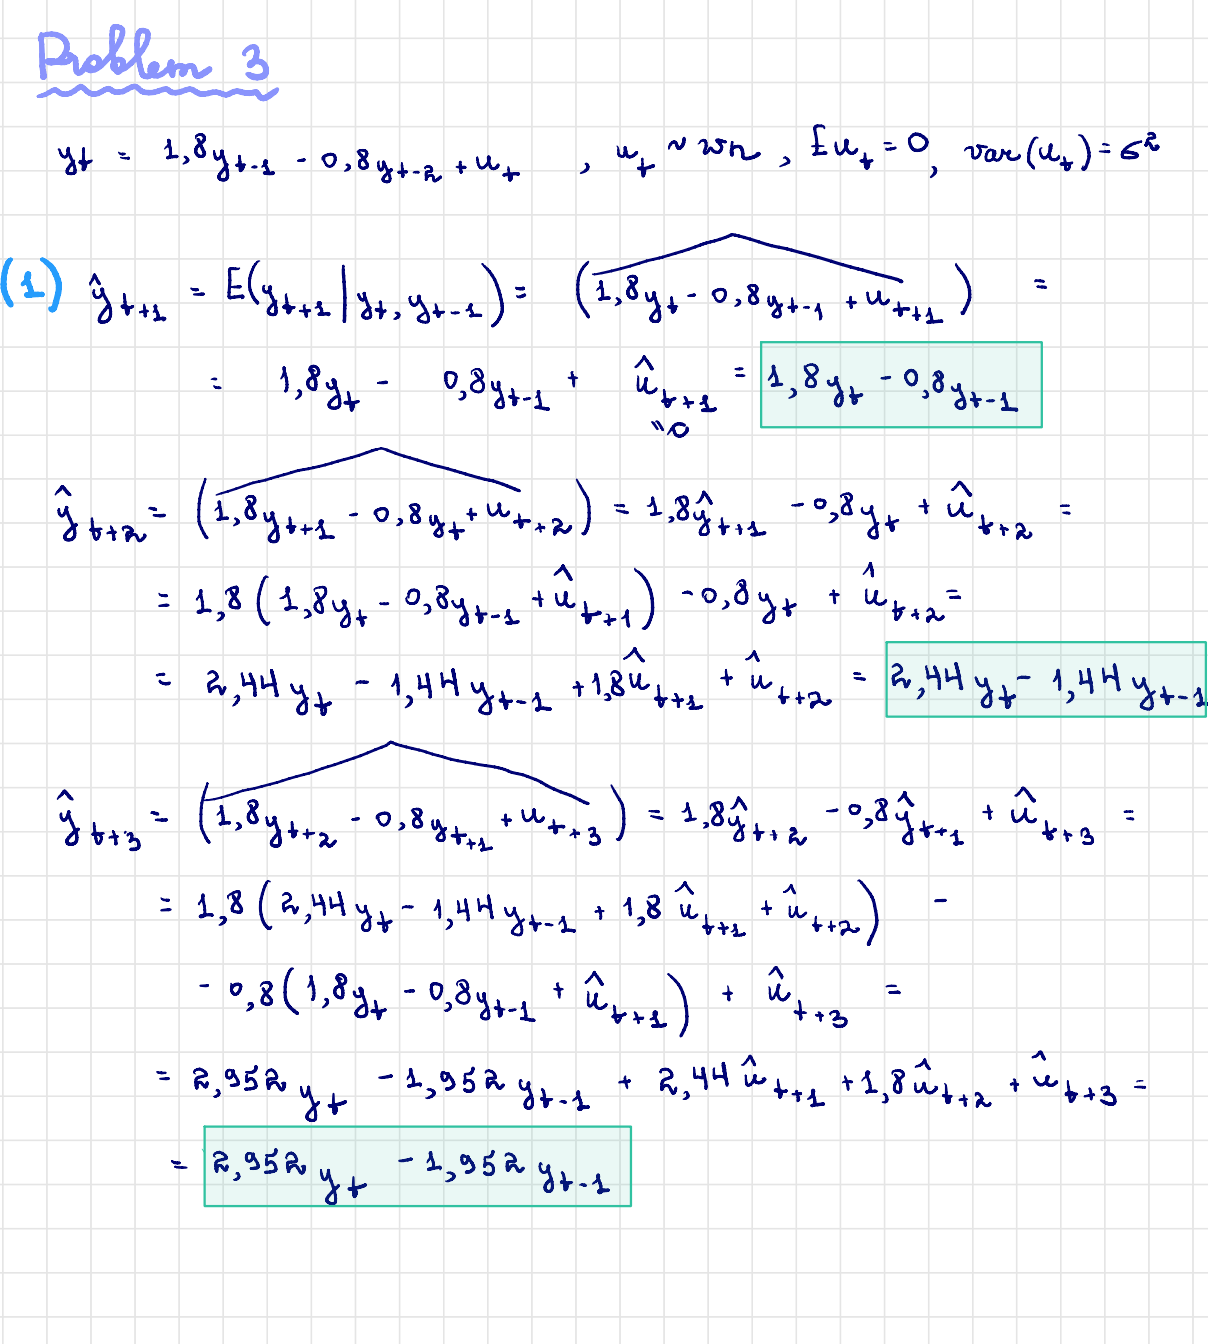

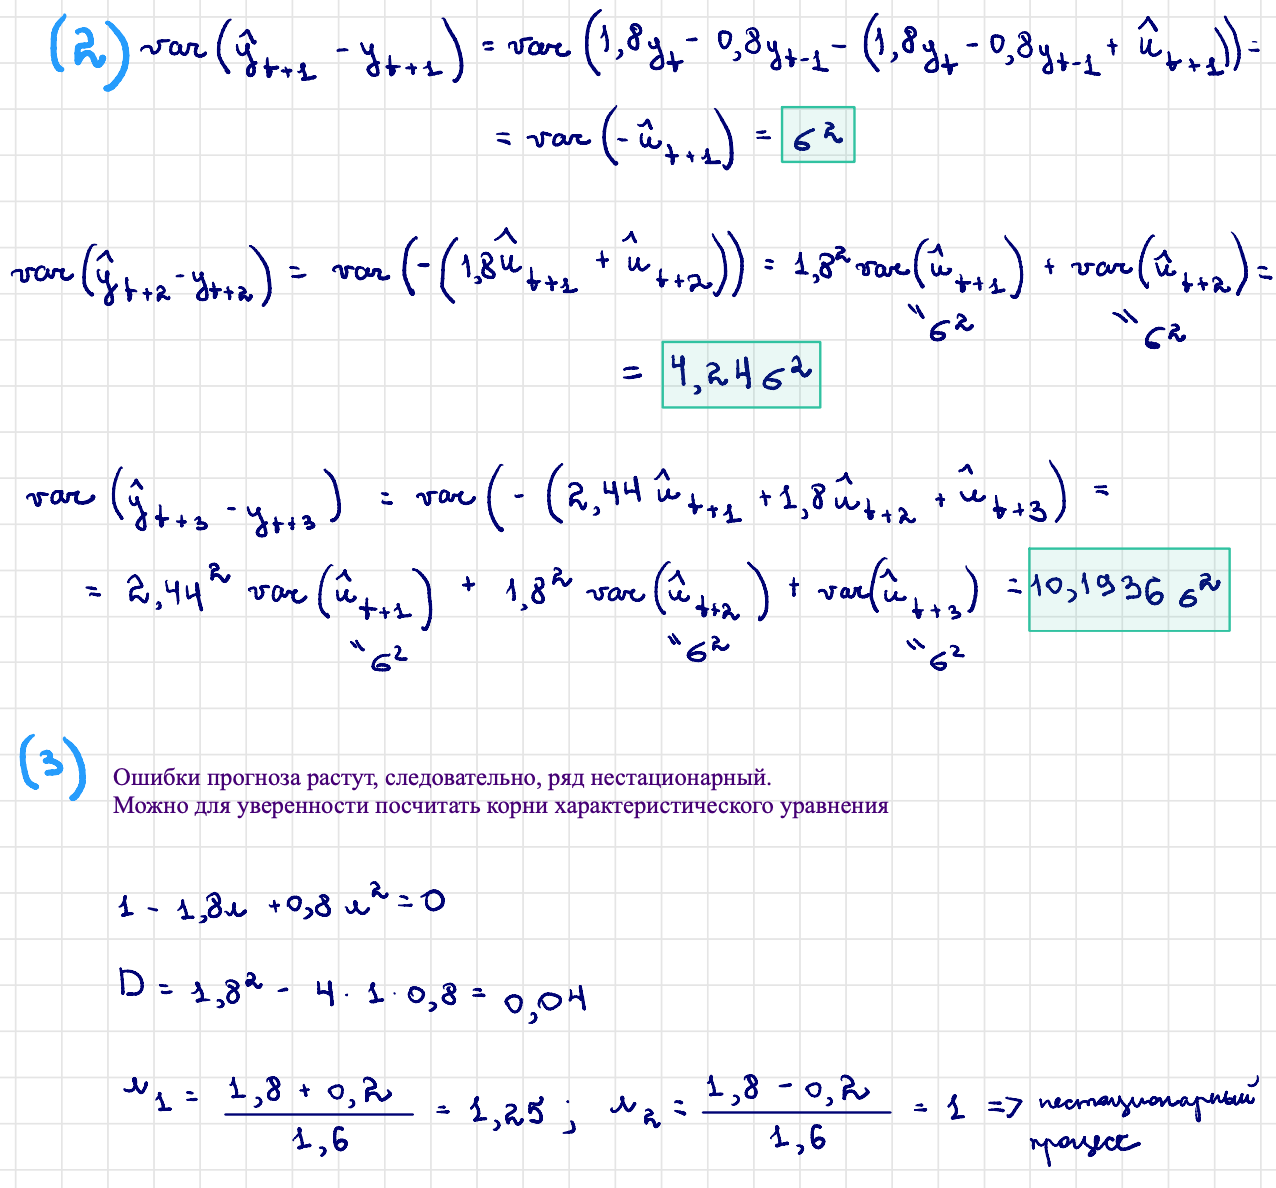